In [1]:
import numpy as np
import pandas as pd

In [2]:
# jupyter labextension install plotlywidget
pd.options.plotting.backend = "plotly"

In [3]:
ADS_DATA_RI = "https://raw.githubusercontent.com/justmarkham/scikit-learn-videos/master/data/Advertising.csv"

dataf = pd.read_csv(ADS_DATA_RI, index_col=0)
dataf.sample(4, random_state=42)

TV  Radio  Newspaper  Sales
96   163.3   31.6       52.9   16.9
16   195.4   47.7       52.9   22.4
31   292.9   28.3       43.2   21.4
159   11.7   36.9       45.2    7.3

In [5]:
from sklearn.model_selection import train_test_split

# split my data to test the performance of the model
X, y = dataf[["TV"]], dataf["Sales"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=7
)

fig_size = {"width": 1200, "height": 600}
# fig_size = {"width":800, "height":400}

(
    dataf.assign(
        split=lambda d: np.where(d.index.isin(X_train.index), "train", "test")
    ).plot(
        kind="scatter",
        x="TV",
        y="Sales",
        color="split",
        trendline="ols",
        trendline_scope="overall",
        trendline_color_override="darkblue",
        opacity=0.7,
        title="Sales ~ TV Ads",
        **fig_size,
    )
)

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [6]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X_train, y_train)

LinearRegression()

In [7]:
from numpy.typing import NDArray

In [8]:
def get_equation(
    features: NDArray[str],
    coef: NDArray[float],
    intercept: float,
    y: str = "Sales",
) -> str:
    equation = " + ".join(
        [
            *[f"{coef:.5f} * {feature}" for feature, coef in zip(features, coef)],
            f"{intercept:.5f}",
        ]
    )

    return f"{y} ~ {equation}"

In [9]:
y_func = get_equation(
    features=lm.feature_names_in_, coef=lm.coef_, intercept=lm.intercept_
)
y_func

'Sales ~ 0.04727 * TV + 7.17408'

In [10]:
y_pred = lm.predict(X_test)
R2 = f"{metrics.r2_score(y_true=y_test, y_pred=y_pred):.4f}"
RMSE = f"{metrics.mean_squared_error(y_test, y_pred, squared=False):.4f}"
R2, RMSE

('0.6779', '2.9410')

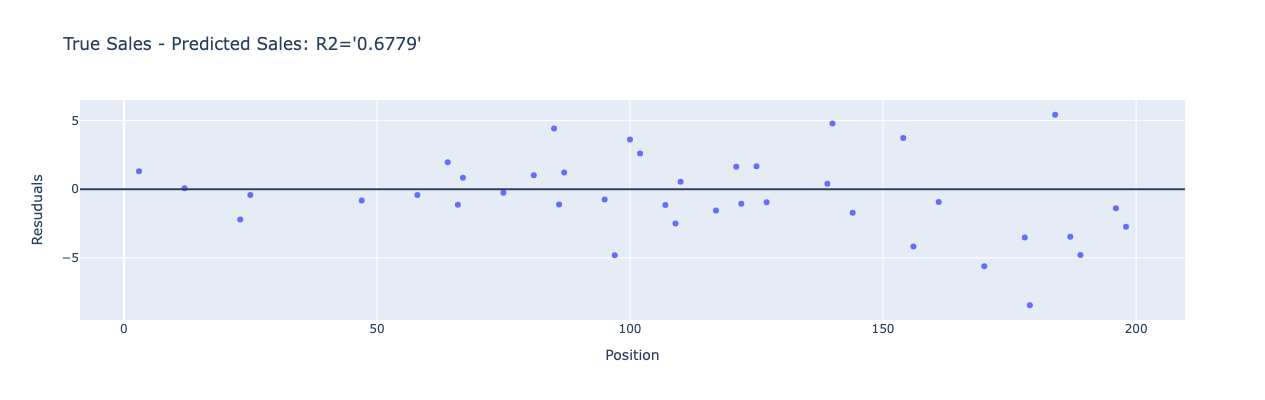

In [11]:
(
    pd.DataFrame(y_test - y_pred)
    .rename(columns={"Sales": "Resuduals"})
    .assign(TV=X_test, Position=X_test.index)
    .plot(
        kind="scatter",
        y="Resuduals",
        x="Position",
        title=f"True Sales - Predicted Sales: {R2=} ",
        **fig_size,
    )
    .add_hline(y=0)
    .update_traces(mode="markers", hovertemplate=None)
    .update_layout(hovermode="y unified")
)

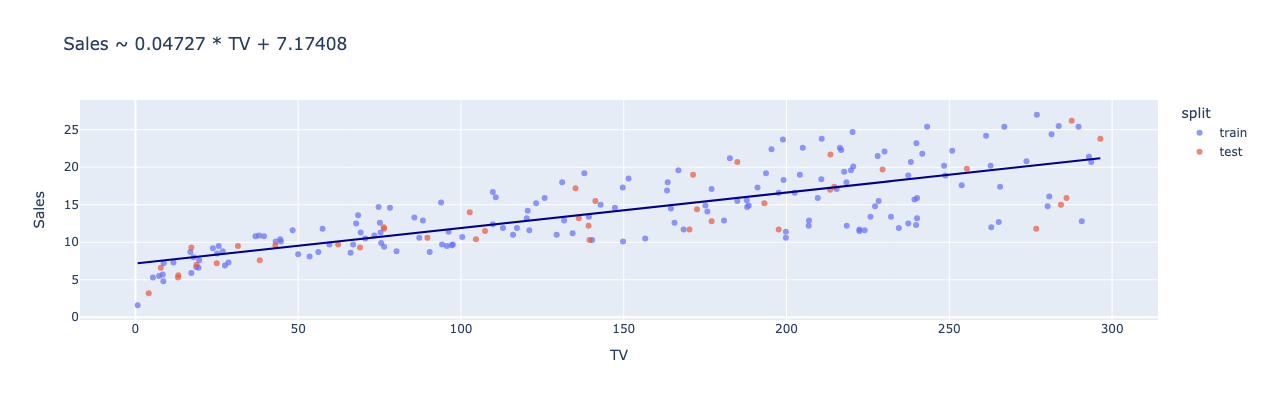

In [12]:
(
    dataf.assign(
        split=lambda d: np.where(d.index.isin(X_train.index), "train", "test")
    ).plot(
        kind="scatter",
        x="TV",
        y="Sales",
        color="split",
        opacity=0.7,
        title=f"{y_func}",
        **fig_size,
    )
).add_traces(
    (
        dataf.plot(
            kind="line", x="TV", y=lm.predict(dataf[["TV"]]), **fig_size
        ).update_traces(line_color="darkblue")
    ).data
)


#

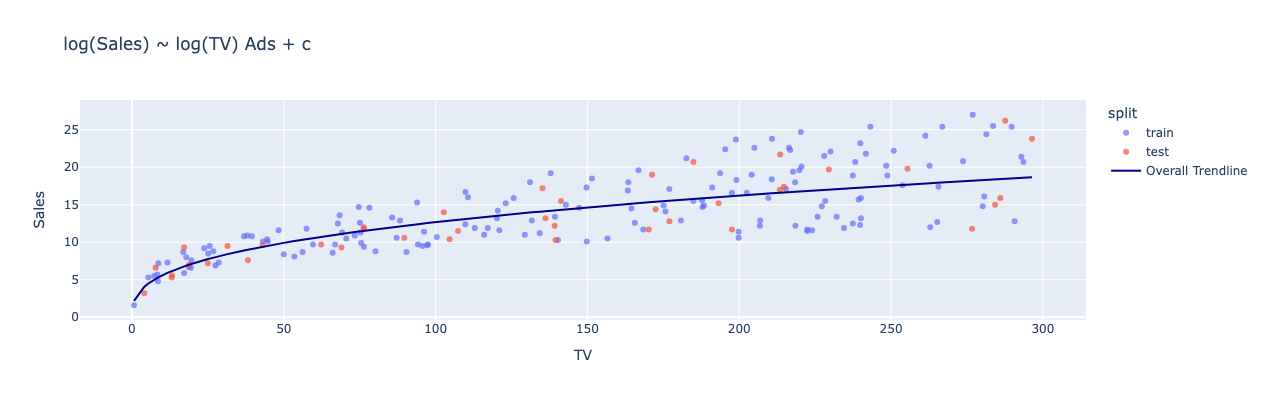

In [13]:
# Data Transformation


(
    dataf.assign(
        split=lambda d: np.where(d.index.isin(X_train.index), "train", "test")
    ).plot(
        kind="scatter",
        x="TV",
        y="Sales",
        color="split",
        trendline="ols",
        trendline_options=dict(log_x=True, log_y=True),  # power of transformation
        trendline_scope="overall",
        trendline_color_override="darkblue",
        opacity=0.7,
        title="log(Sales) ~ log(TV) Ads + c",
        **fig_size,
    )
)

In [14]:
# scikit-learn edition
from functools import partial
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [15]:
def inverse_log10(X):
    return 10**X


Xt = FunctionTransformer(func=np.log10, inverse_func=inverse_log10)
model = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log10, inverse_func=inverse_log10
)

lmx = make_pipeline(Xt, model)
lmx.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log10'>,
                                     inverse_func=<function inverse_log10 at 0x7fceeb922660>)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<function inverse_log10 at 0x7fceeb922660>,
                                            regressor=LinearRegression()))])

In [16]:
y_pred = lmx.predict(X_test)
R2 = f"{metrics.r2_score(y_true=y_test, y_pred=y_pred):.4f}"
RMSE = f"{metrics.mean_squared_error(y_test, y_pred, squared=False):.4f}"

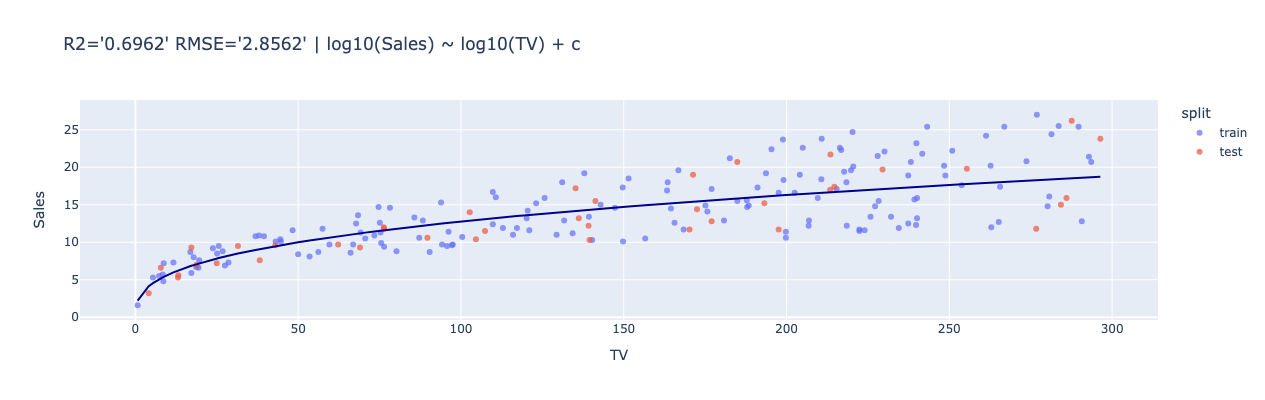

In [17]:
(
    dataf.assign(
        split=lambda d: np.where(d.index.isin(X_train.index), "train", "test")
    ).plot(
        kind="scatter",
        x="TV",
        y="Sales",
        color="split",
        opacity=0.7,
        title=f"{R2=} {RMSE=} | log10(Sales) ~ log10(TV) + c",
        **fig_size,
    )
).add_traces(
    (
        dataf.assign(pred=lmx.predict(dataf[["TV"]]))
        .sort_values(by=["TV"])
        .plot(kind="line", x="TV", y="pred", **fig_size)
        .update_traces(line_color="darkblue")
    ).data
)

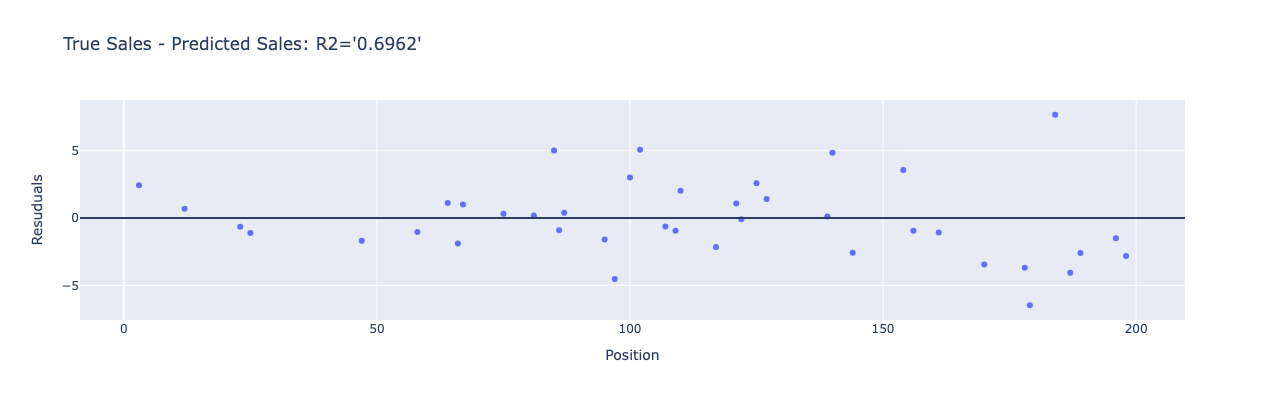

In [18]:
(
    pd.DataFrame(y_test - y_pred)
    .rename(columns={"Sales": "Resuduals"})
    .assign(TV=X_test, Position=X_test.index)
    .plot(
        kind="scatter",
        y="Resuduals",
        x="Position",
        title=f"True Sales - Predicted Sales: {R2=} ",
        **fig_size,
    )
    .add_hline(y=0)
    .update_traces(mode="markers", hovertemplate=None)
    .update_layout(hovermode="y unified")
)

In [19]:
import arviz as az
import pymc as pm
import xarray as xr

$$
\log{(\text{Sales}_i)} = \beta_0 + \beta_1 \log{(\text{TV}_i)} + \varepsilon_i
$$

In [20]:
log_Sales, log_TV = np.log10(y_train.to_numpy()), np.log10(X_train["TV"].to_numpy())

with pm.Model() as model:
    log_Sales_ = pm.MutableData("log_Sales", log_Sales)
    log_TV_ = pm.MutableData("log_TV", log_TV)

    β0 = pm.Normal(
        "β0",
        mu=0,
        sigma=20,
    )
    β1 = pm.Normal(
        "β1",
        mu=0,
        sigma=20,
    )
    sigma = pm.HalfNormal("σ", sigma=10)

    mu = β0 + β1 * log_TV_
    pm.Normal("log(Sales)", mu=mu, sigma=sigma, observed=log_Sales_, shape=mu.shape)

$$
\begin{aligned}
\beta_0 & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\beta_1 & \sim \text{Normal}(0, \sigma_{\beta_1}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\mu_i & = \beta_0 + \beta_1 \log{(\text{TV}_i)} \\
\log{(\text{Sales}_i)} & \sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

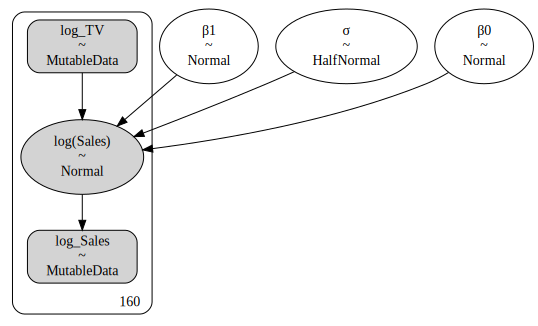

In [21]:
# sudo apt install graphviz
pm.model_to_graphviz(model)

In [22]:
with model:
    idata = pm.sample(3000, chains=4, target_accept=0.85, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β1, σ]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 10 seconds.


In [23]:
az.summary(idata, round_to=2, kind="stats")

mean    sd  hdi_3%  hdi_97%
β0  0.40  0.04    0.33     0.47
β1  0.35  0.02    0.32     0.38
σ   0.09  0.01    0.08     0.10

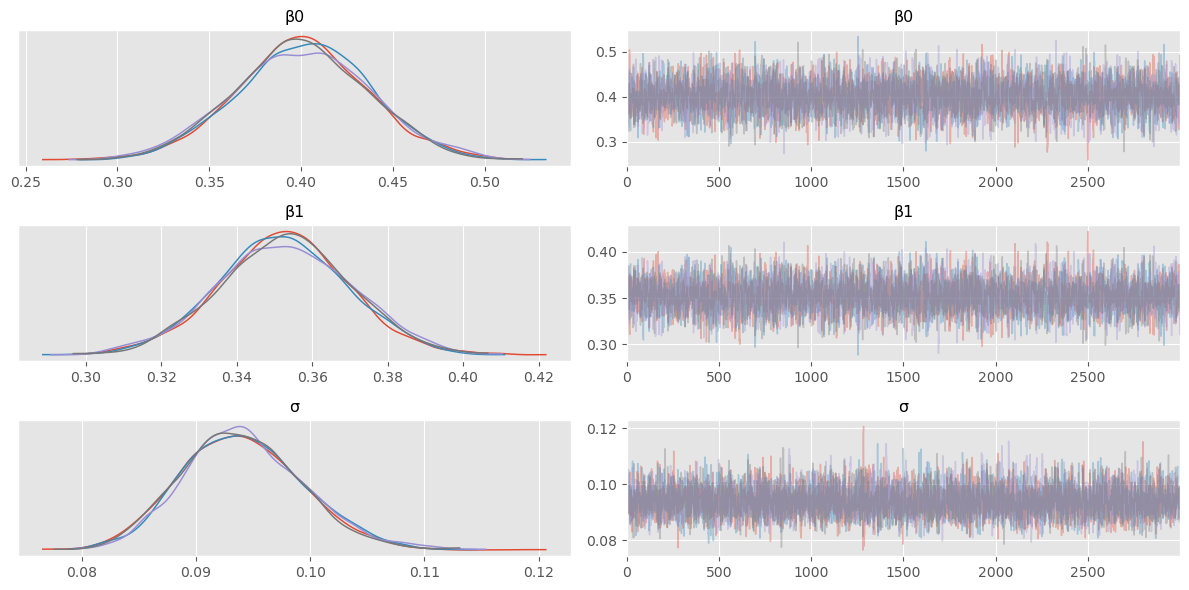

In [24]:
import matplotlib as mpl

mpl.style.use("ggplot")

az.plot_trace(idata, compact=False, backend_kwargs={"tight_layout": True});

In [25]:
# add test
with model:
    pm.set_data({"log_TV": np.log10(X_test["TV"].to_numpy())})

    pm.sample_posterior_predictive(
        idata,
        predictions=True,
        extend_inferencedata=True,
        random_seed=42,
    )

Sampling: [log(Sales)]


In [26]:
y_pred = 10 ** idata.predictions["log(Sales)"].mean(dim=["chain", "draw"]).data

In [32]:
R2, RMSE = (
    metrics.r2_score(y_test, y_pred),
    metrics.mean_squared_error(y_test, y_pred, squared=False),
)
R2, RMSE

(0.6949903971655622, 2.8620992998783623)

In [ ]:
β0 = idata.posterior["β0"][:, ::25].to_numpy().flatten()
β1 = idata.posterior["β1"][:, ::25].to_numpy().flatten()

In [29]:
from collections import defaultdict

container = defaultdict(list)

for b0, b1, i in zip(β0, β1, range(len(β1))):
    container[f"Sales_{i}"].extend(10 ** (b0 + b1 * np.log10(X_train["TV"])))
container["Sales_mean"].extend(
    10 ** (β0.mean().item() + β1.mean().item() * np.log10(X_train["TV"]))
)
container["Sales"].extend(y_train)
container["TV"].extend(X_train["TV"])

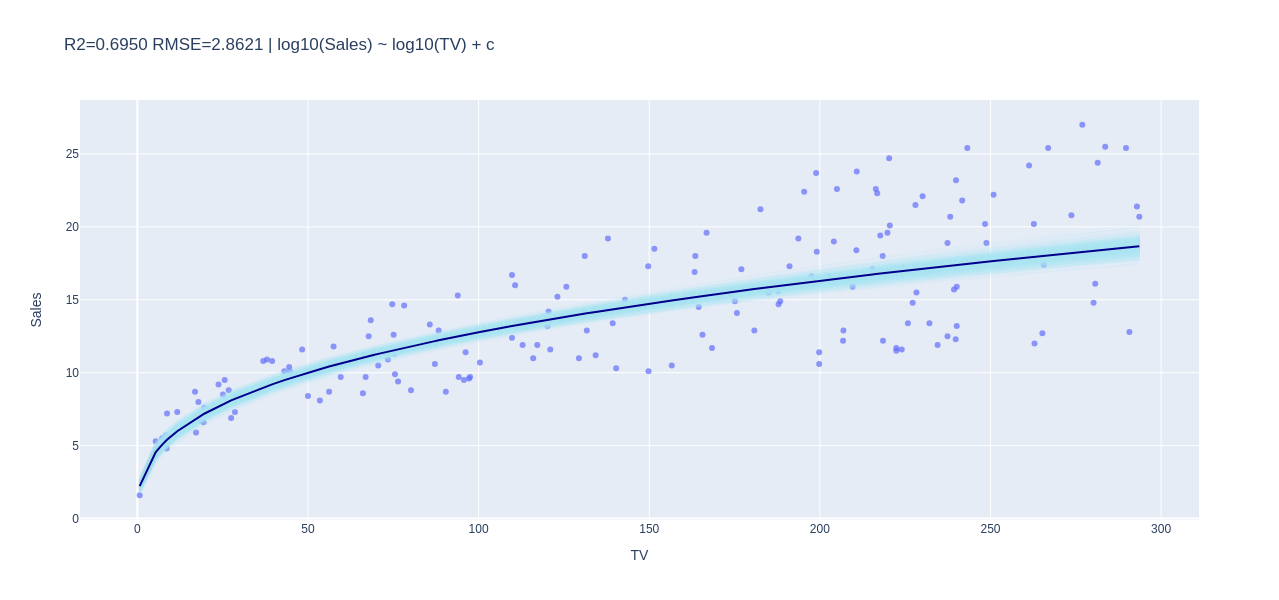

In [35]:
p = pd.DataFrame(container)

fig = p.plot(
    kind="scatter",
    x="TV",
    y="Sales",
    opacity=0.7,
    title=f"{R2=:.4f} {RMSE=:.4f} | log10(Sales) ~ log10(TV) + c",
    **fig_size,
)

for column in p.columns[:-3]:
    fig = fig.add_traces(
        (
            p.sort_values(by=["TV"])
            .plot(kind="line", x="TV", y=column, **fig_size)
            .update_traces(
                line_color="lightblue",
                opacity=0.07,
            )
        ).data
    )

fig.add_traces(
    (
        p.sort_values(by=["TV"])
        .plot(kind="line", x="TV", y="Sales_mean", **fig_size)
        .update_traces(line_color="darkblue")
    ).data
)